# Model Monitoring

Proof of concept model monitoring dashboard to monitor key metrics and aid the CreditKarma Suite maintainers in selecting the best model for deployment.

In [1]:
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark
import numpy as np
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta

import mlflow
from mlflow.tracking import MlflowClient

from sklearn.metrics import fbeta_score

In [2]:
spark = pyspark.sql.SparkSession.builder \
    .appName("model-training") \
    .master("local[*]") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 12:53:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
def read_gold_table(table, gold_db, spark):
    """
    Helper function to read all partitions of a gold table
    """
    folder_glob_path = os.path.join(gold_db, table, '*')
    files_list = glob.glob(folder_glob_path, recursive=True)
    files_list = [f for f in files_list]
    df = spark.read.option("header", "true").option("mergeSchema", "true").parquet(*files_list)
    return df

In [4]:
X_spark = read_gold_table('feature_store', 'datamart/gold', spark)
y_spark = read_gold_table('label_store', 'datamart/gold', spark)

In [5]:
X_df = X_spark.toPandas().sort_values(by='customer_id')
y_df = y_spark.toPandas().sort_values(by='customer_id')

25/06/26 12:54:28 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [6]:
model_train_date_str = "2024-12-01" 
model_train_date = datetime.strptime(model_train_date_str, "%Y-%m-%d").date()
months_of_interest = 12
start_date = model_train_date - relativedelta(months=months_of_interest)

y_model_df = y_df[(y_df['snapshot_date'] >= start_date) &
                  (y_df['snapshot_date'] < model_train_date)]
X_model_df = X_df[np.isin(X_df['customer_id'], y_model_df['customer_id'].unique())]

joined_df = pd.merge(X_model_df, y_model_df, on=['customer_id'])

In [7]:
X_columns = [col for col in X_model_df.columns if col != 'snapshot_date' and col != 'customer_id']
y_columns = ['label', 'snapshot_date_y']

joined_df = joined_df[['customer_id', *X_columns, *y_columns]]
joined_df['snapshot_date_str'] = joined_df['snapshot_date_y'].astype(str)

In [8]:
joined_df

,customer_id,age,annual_income,monthly_inhand_salary,num_bank_accounts,num_credit_card,interest_rate,num_of_loan,delay_from_due_date,num_of_delayed_payment,...,credit_mix_good,credit_mix_bad,payment_behaviour_spent_low,payment_behaviour_spent_high,payment_behaviour_value_small,payment_behaviour_value_medium,payment_behaviour_value_large,label,snapshot_date_y,snapshot_date_str
0,CUS_0x100b,19.0,113781.390625,9549.782227,1.0,4.0,1.0,0.0,14.0,8.0,...,1,0,0,1,1,0,0,0,2024-09-01,2024-09-01
1,CUS_0x1011,44.0,58918.468750,5208.872559,3.0,3.0,17.0,3.0,27.0,13.0,...,0,0,1,0,0,1,0,0,2024-05-01,2024-05-01
2,CUS_0x1013,44.0,98620.976562,7962.415039,3.0,3.0,6.0,3.0,12.0,9.0,...,1,0,0,1,0,1,0,0,2024-06-01,2024-06-01
3,CUS_0x1015,27.0,46951.019531,3725.584961,7.0,4.0,16.0,0.0,8.0,9.0,...,0,0,1,0,1,0,0,0,2024-02-01,2024-02-01
4,CUS_0x1018,15.0,61194.808594,5014.567383,7.0,7.0,23.0,8.0,19.0,22.0,...,0,1,0,1,0,1,0,1,2024-05-01,2024-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5903,CUS_0xfe4,29.0,110575.718750,9009.643555,7.0,3.0,6.0,7.0,10.0,13.0,...,0,0,0,1,1,0,0,0,2024-03-01,2024-03-01
5904,CUS_0xfe5,38.0,96960.210938,7934.017578,6.0,4.0,8.0,0.0,24.0,12.0,...,0,0,0,1,0,0,1,0,2023-12-01,2023-12-01
5905,CUS_0xfea,33.0,44264.410156,3755.700928,3.0,3.0,6.0,2.0,11.0,2.0,...,1,0,1,0,1,0,0,0,2024-04-01,2024-04-01
5906,CUS_0xffc,18.0,60877.171875,5218.097656,6.0,8.0,27.0,8.0,46.0,14.0,...,0,0,0,1,0,0,1,1,2024-07-01,2024-07-01


In [9]:
def get_all_model_versions(model_name: str):
    client = MlflowClient()
    all_versions = []
    page_token = None

    while True:
        result = client.search_model_versions(
            filter_string=f"name='{model_name}'",
            max_results=100,  # Maximum allowed
            page_token=page_token
        )
        all_versions.extend(result)
        if hasattr(result, 'token') and result.token:
            page_token = result.token
        else:
            break

    return all_versions

# Data Distribution Monitoring

## Distribution of customer attributes by month

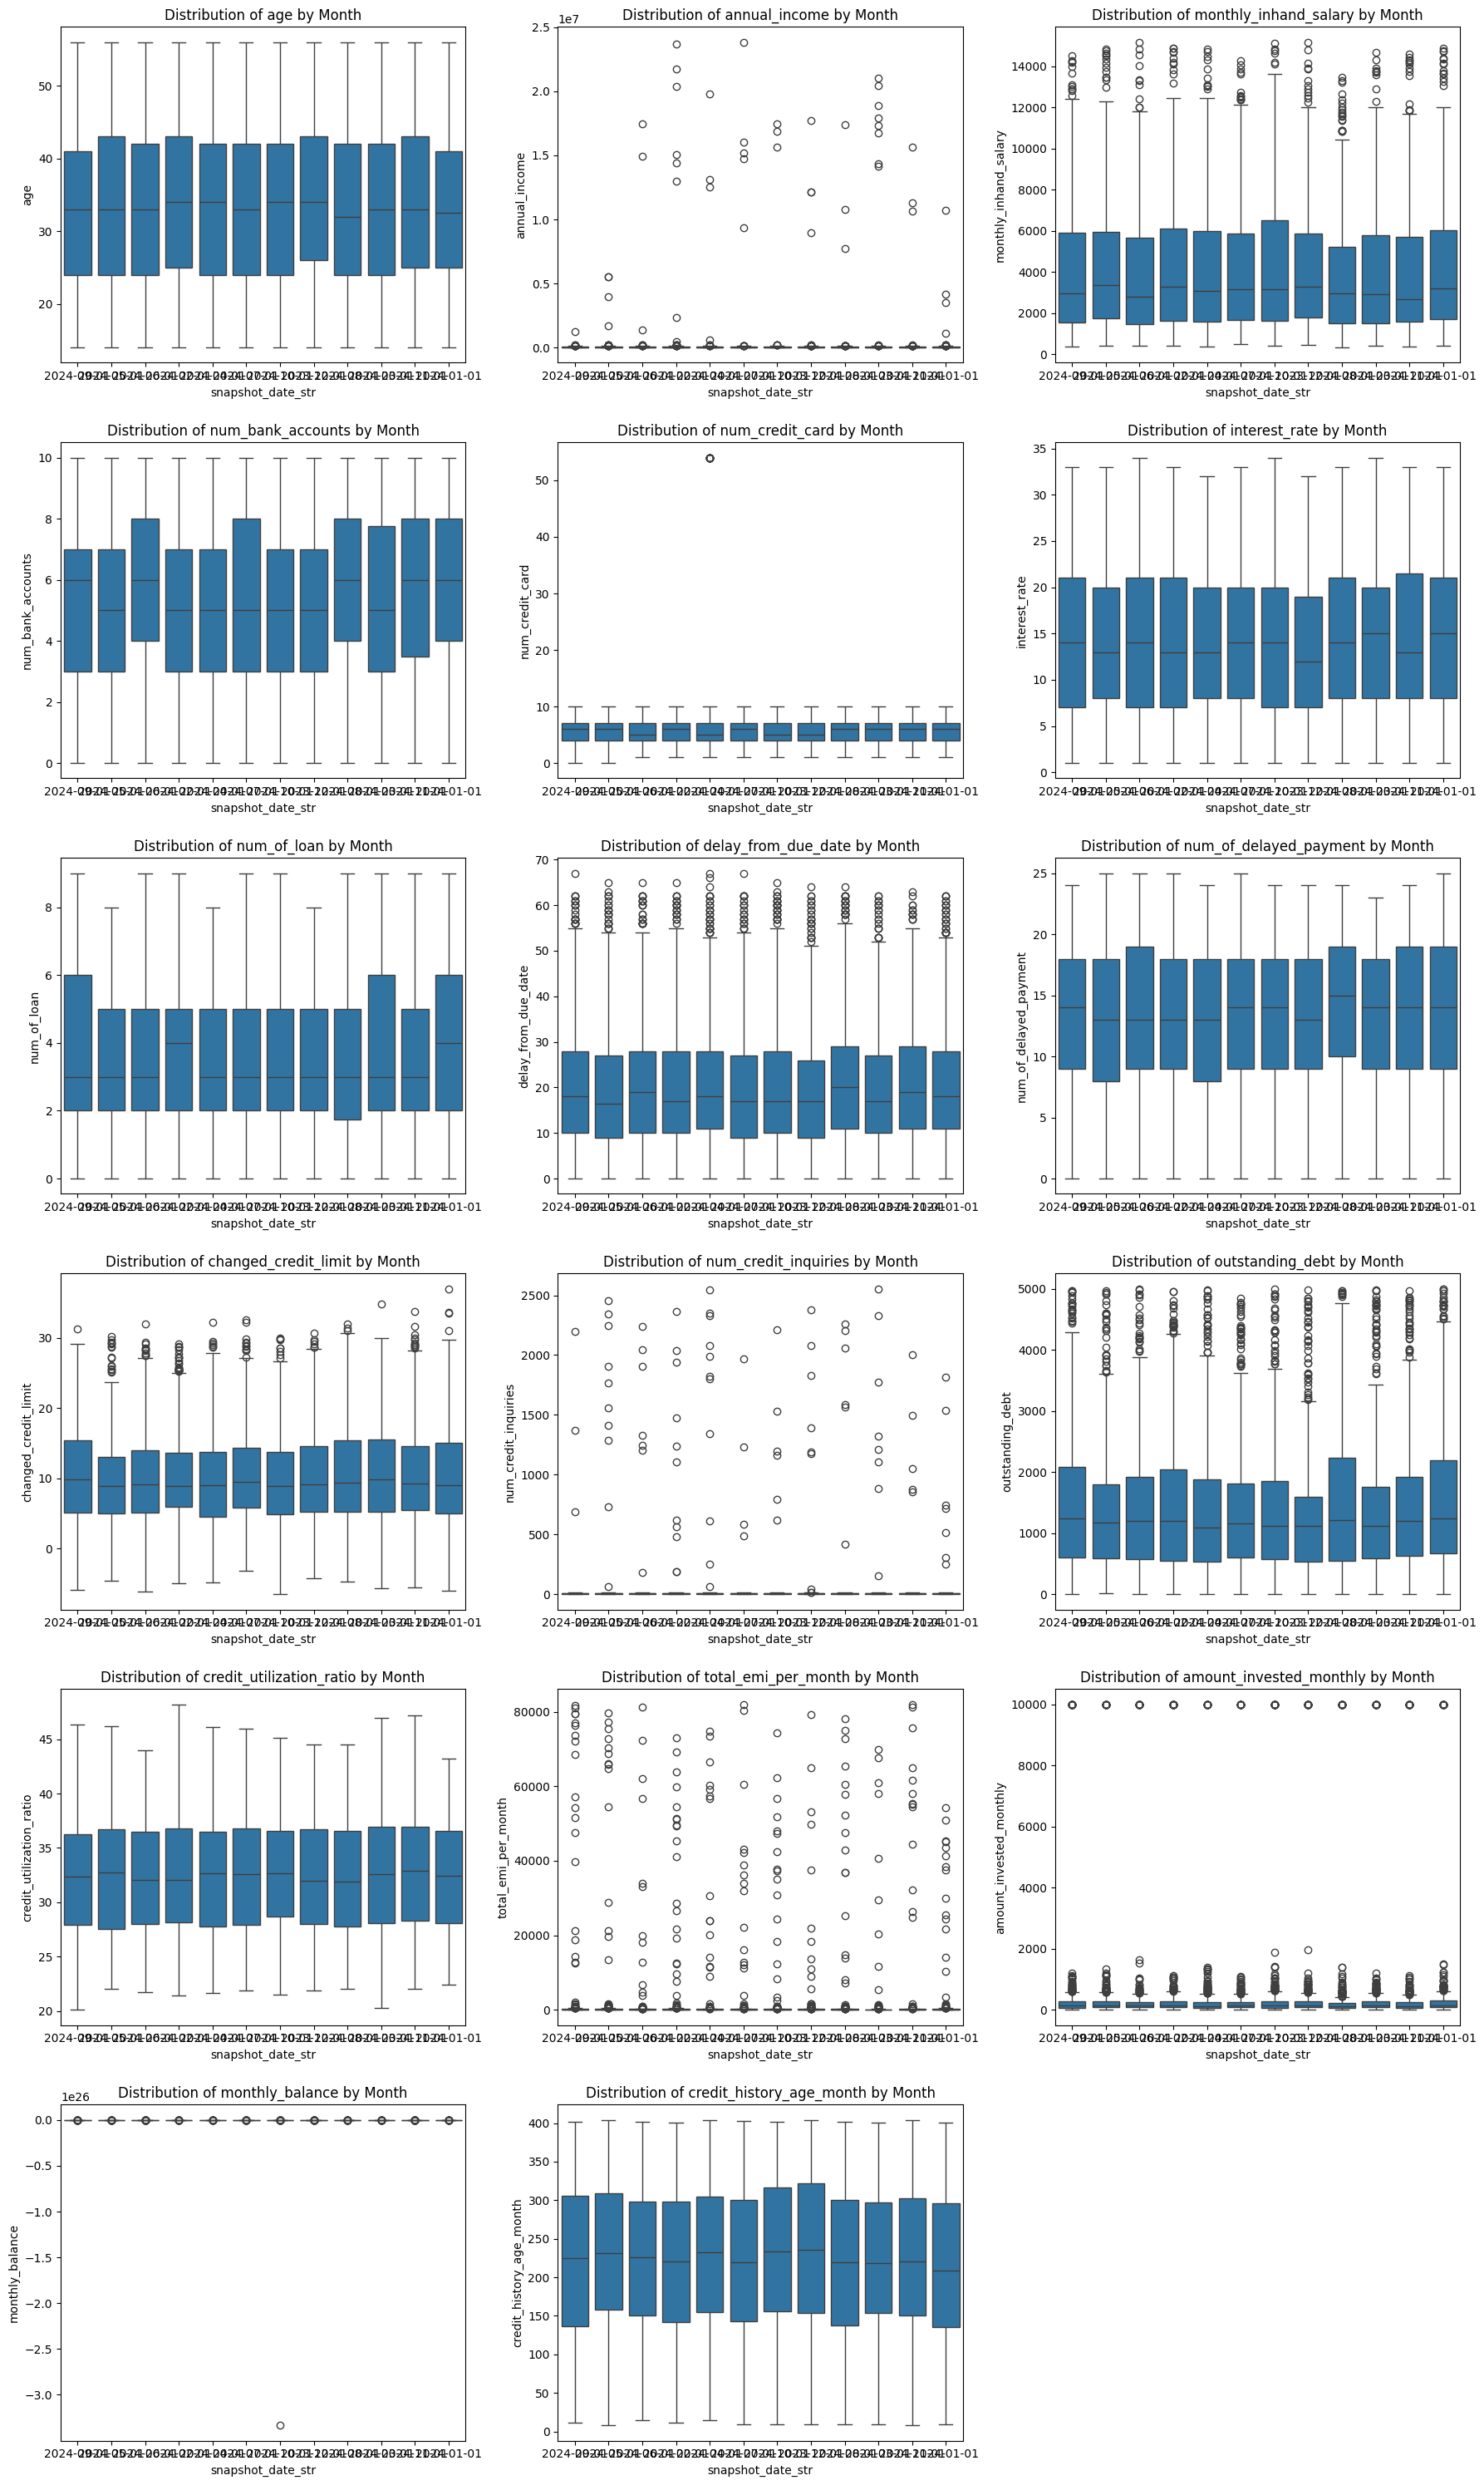

In [10]:
# Set up subplots
selected_columns = [
 'age',
 'annual_income',
 'monthly_inhand_salary',
 'num_bank_accounts',
 'num_credit_card',
 'interest_rate',
 'num_of_loan',
 'delay_from_due_date',
 'num_of_delayed_payment',
 'changed_credit_limit',
 'num_credit_inquiries',
 'outstanding_debt',
 'credit_utilization_ratio',
 'total_emi_per_month',
 'amount_invested_monthly',
 'monthly_balance',
 'credit_history_age_month'
]

n_cols = 3  # number of columns in the subplot grid
n_rows = (len(selected_columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows), squeeze=False)

# Plot each column
for idx, col in enumerate(selected_columns):
    r, c = divmod(idx, n_cols)
    sns.boxplot(x='snapshot_date_str', y=col, data=joined_df, ax=axes[r][c])
    axes[r][c].set_title(f'Distribution of {col} by Month')
    axes[r][c].tick_params(axis='x')

for idx in range(len(selected_columns), n_rows * n_cols):
    r, c = divmod(idx, n_cols)
    fig.delaxes(axes[r][c])

plt.tight_layout()
plt.show()

In [15]:
def calculate_psi(base, current, buckets=10):
    breakpoints = np.percentile(base, np.linspace(0, 100, buckets + 1))

    base_counts = np.histogram(base, bins=breakpoints)[0] / len(base)
    current_counts = np.histogram(current, bins=breakpoints)[0] / len(current)

    # Avoid division by zero or log(0)
    base_counts = np.where(base_counts == 0, 0.0001, base_counts)
    current_counts = np.where(current_counts == 0, 0.0001, current_counts)

    psi = np.sum((base_counts - current_counts) * np.log(base_counts / current_counts))
    return psi

def calculate_monthly_psi(df, feature_cols, date_col='snapshot_date', buckets=10):
    df = df.copy()

    psi_results = {}

    dates = sorted(df[date_col].unique())

    for i in range(1, len(dates)):
        prev_month = dates[i - 1]
        curr_month = dates[i]
        df_prev = df[df[date_col] == prev_month]
        df_curr = df[df[date_col] == curr_month]

        pair_label = f"{prev_month}_vs_{curr_month}"
        psi_results[pair_label] = {}

        for feature in feature_cols:
            try:
                psi = calculate_psi(df_prev[feature].dropna(), df_curr[feature].dropna(), buckets)
                psi_results[pair_label][feature] = psi
            except Exception as e:
                psi_results[pair_label][feature] = np.nan

    psi_df = pd.DataFrame(psi_results)
    return psi_df

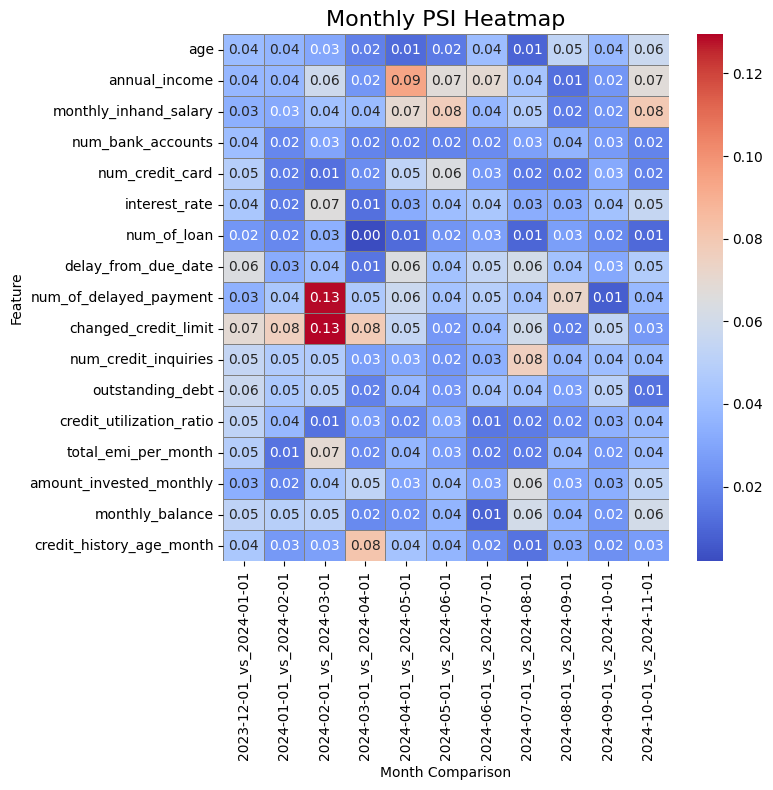

In [17]:
selected_columns = [
 'age',
 'annual_income',
 'monthly_inhand_salary',
 'num_bank_accounts',
 'num_credit_card',
 'interest_rate',
 'num_of_loan',
 'delay_from_due_date',
 'num_of_delayed_payment',
 'changed_credit_limit',
 'num_credit_inquiries',
 'outstanding_debt',
 'credit_utilization_ratio',
 'total_emi_per_month',
 'amount_invested_monthly',
 'monthly_balance',
 'credit_history_age_month'
]

psi_df = calculate_monthly_psi(joined_df, selected_columns, 'snapshot_date_y')
plt.figure(figsize=(8, 8))
sns.heatmap(psi_df, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, linecolor='gray')
plt.title("Monthly PSI Heatmap", fontsize=16)
plt.xlabel("Month Comparison")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## Distribution of labels by month

<Axes: xlabel='snapshot_date_str', ylabel='count'>

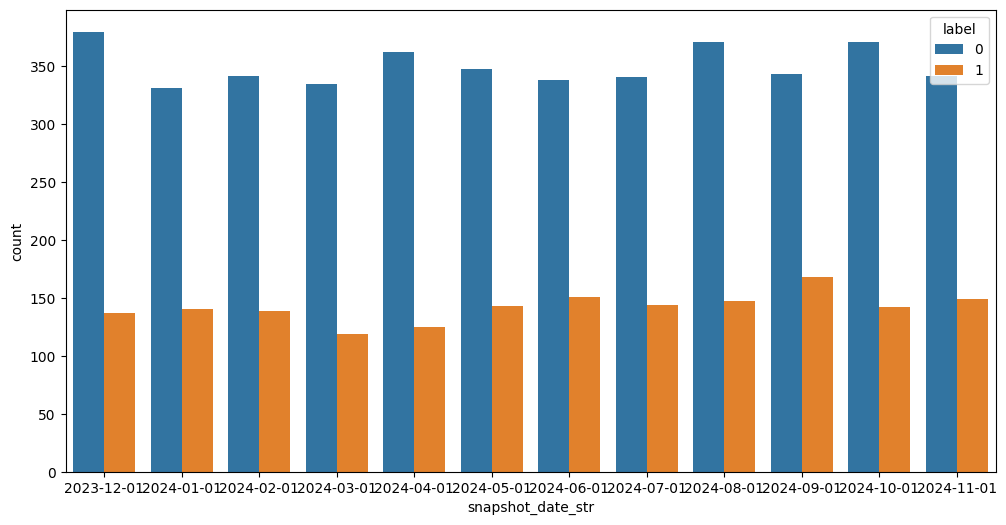

In [24]:
label_counts = joined_df.groupby(['snapshot_date_str', 'label']).size().reset_index(name='count')

# Plot counts of 0 and 1 per month
plt.figure(figsize=(12, 6))
sns.barplot(x='snapshot_date_str', y='count', hue='label', data=label_counts)

## Distribution of labels by variables

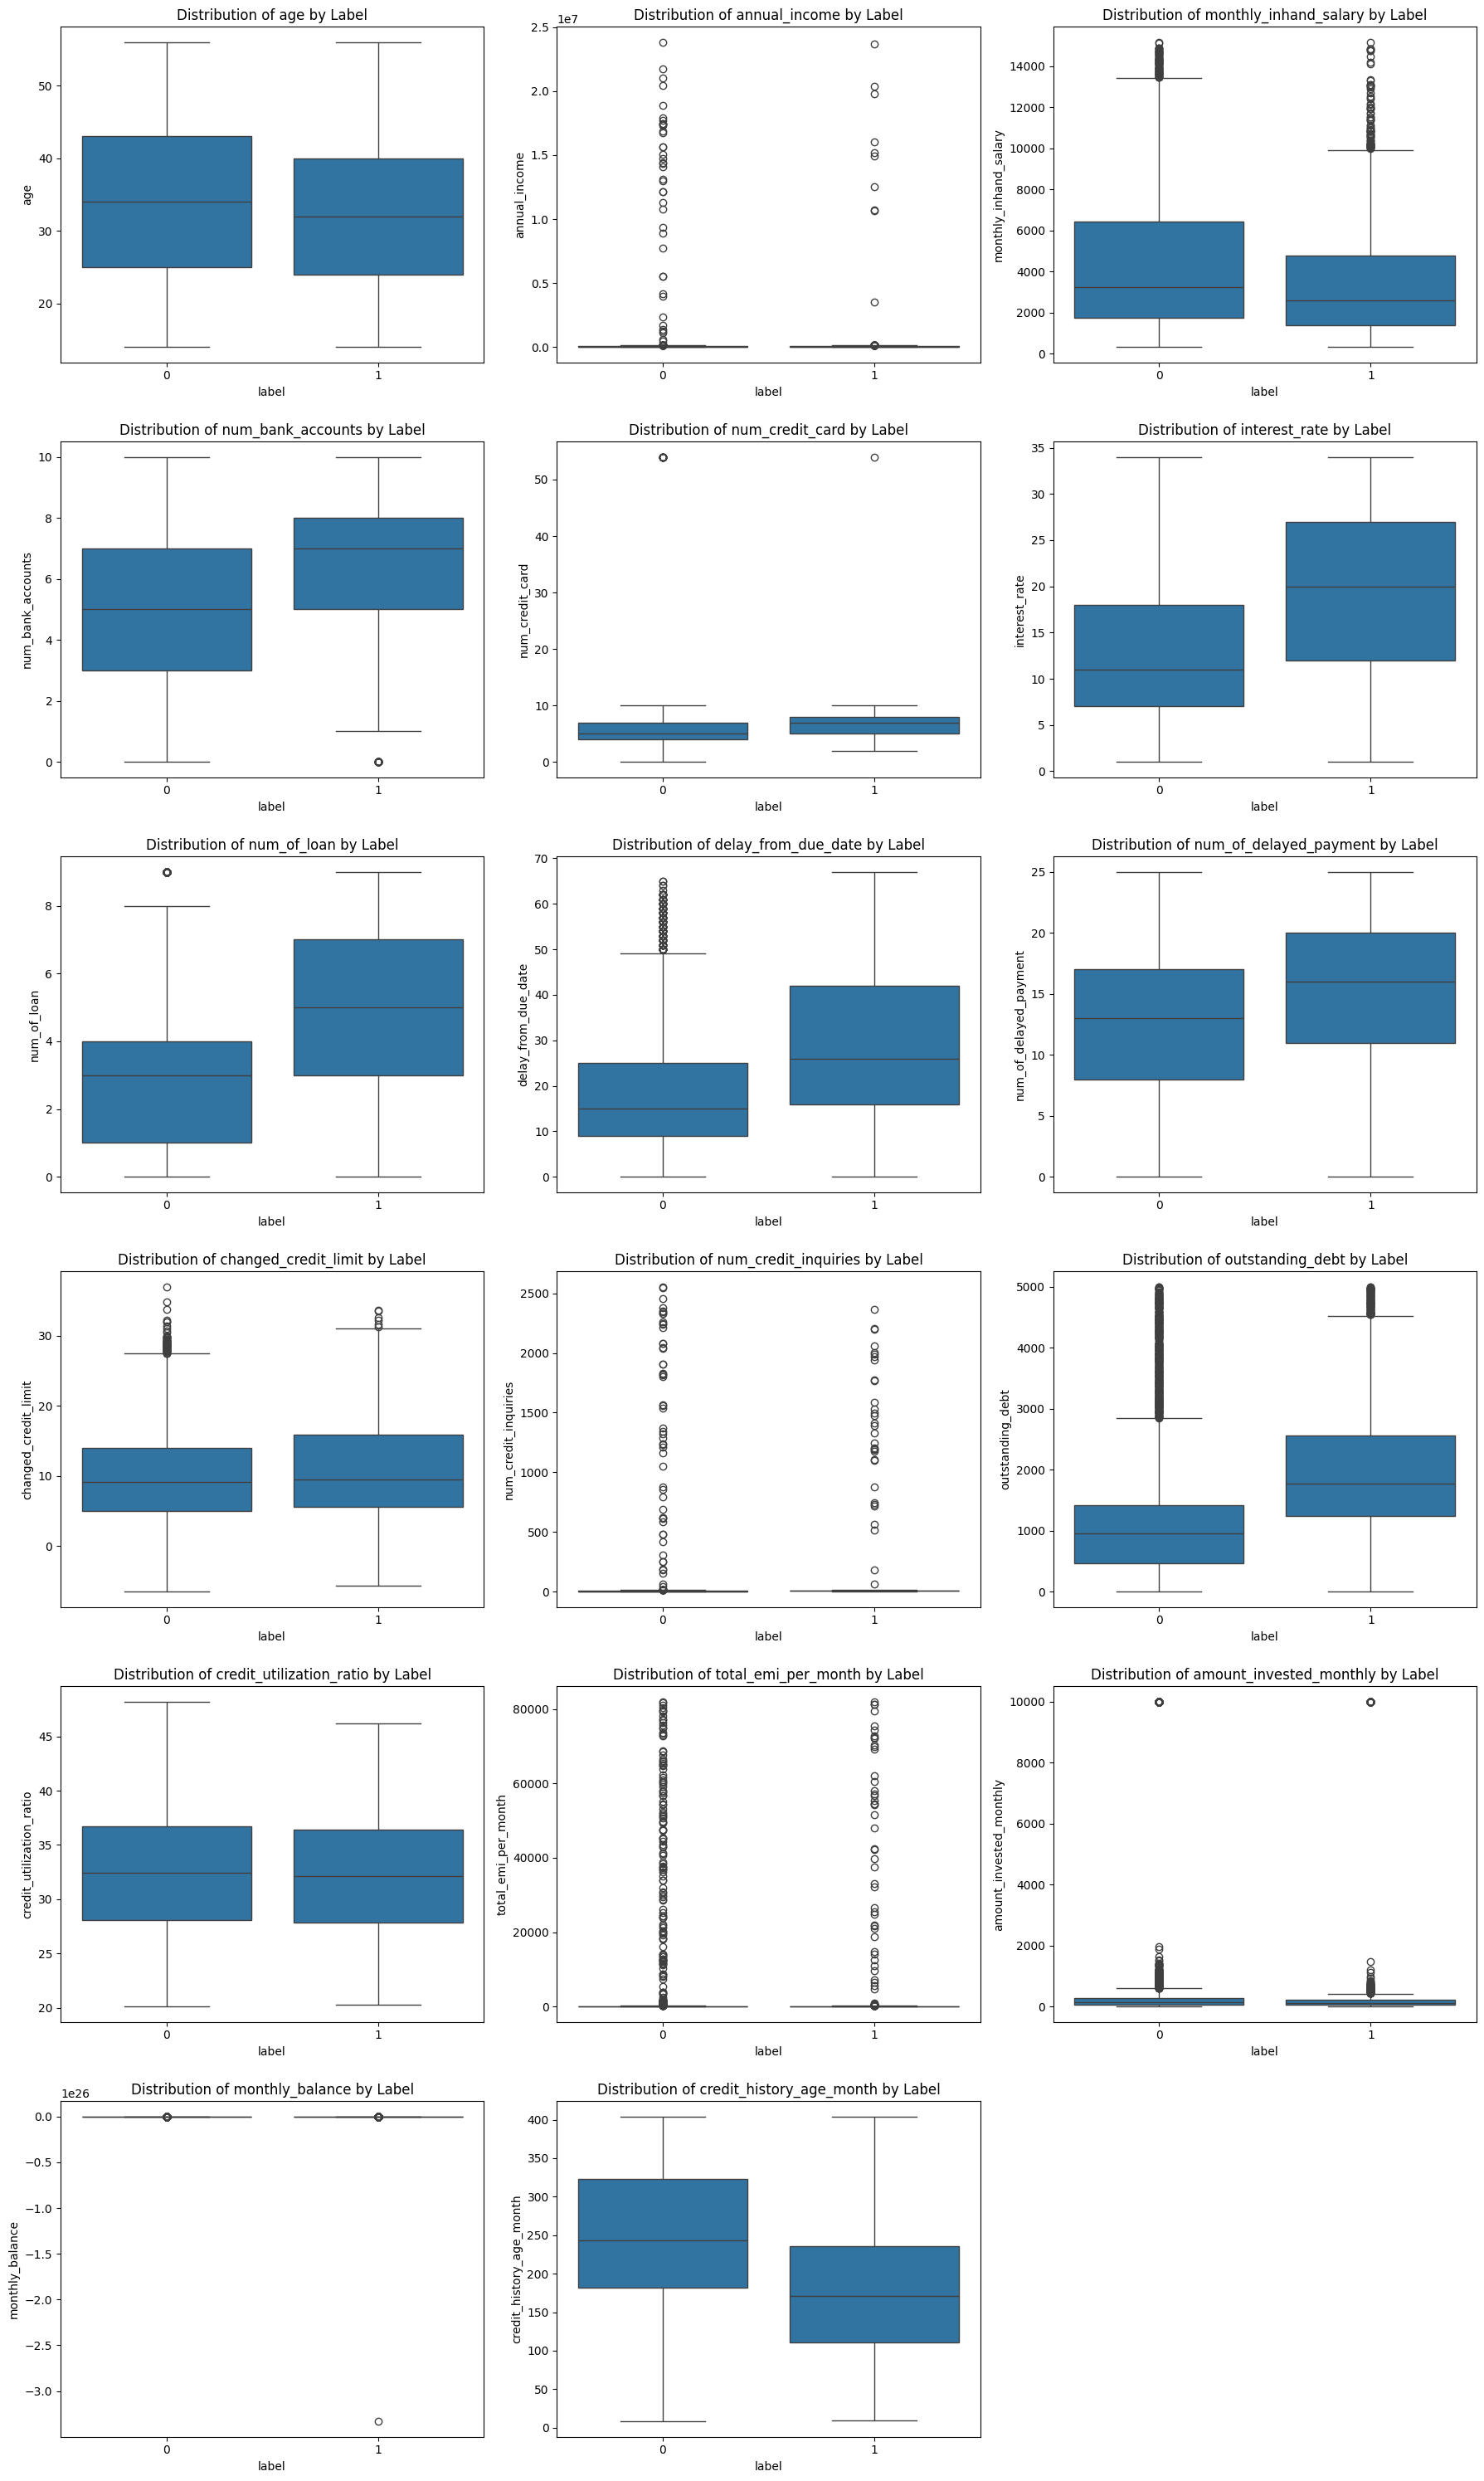

In [25]:
# Set up subplots
selected_columns = [
 'age',
 'annual_income',
 'monthly_inhand_salary',
 'num_bank_accounts',
 'num_credit_card',
 'interest_rate',
 'num_of_loan',
 'delay_from_due_date',
 'num_of_delayed_payment',
 'changed_credit_limit',
 'num_credit_inquiries',
 'outstanding_debt',
 'credit_utilization_ratio',
 'total_emi_per_month',
 'amount_invested_monthly',
 'monthly_balance',
 'credit_history_age_month'
]

n_cols = 3  # number of columns in the subplot grid
n_rows = (len(selected_columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows), squeeze=False)

# Plot each column
for idx, col in enumerate(selected_columns):
    r, c = divmod(idx, n_cols)
    sns.boxplot(x='label', y=col, data=joined_df, ax=axes[r][c])
    axes[r][c].set_title(f'Distribution of {col} by Label')
    axes[r][c].tick_params(axis='x')

for idx in range(len(selected_columns), n_rows * n_cols):
    r, c = divmod(idx, n_cols)
    fig.delaxes(axes[r][c])

plt.tight_layout()
plt.show()

# Model Performance Monitoring

## Current model performance

In [53]:
mlflow.set_tracking_uri(uri="http://mlflow:5001")
model_name = "creditkarma-scorer"

client = MlflowClient()
versions = get_all_model_versions(model_name)

# Retrieve logged metrics from MLFlow
metrics = dict()

for v in versions:
    if v.tags.get("train_date") == model_train_date_str:
        run = client.get_run(v.run_id)
        metrics[v.tags.get("model_type")] = run.data.metrics

# Convert to df
records = []
for model_name, metrics_dict in metrics.items():
    for key, value in metrics_dict.items():
        if 'f1.5_score' in key:
            dataset = key.replace('_f1.5_score', '').capitalize()
            records.append({
                'Model': model_name,
                'Dataset': dataset,
                'Metric': 'F1.5 Score',
                'Value': value
            })
        elif 'auc' in key:
            dataset = key.replace('_auc', '').capitalize()
            records.append({
                'Model': model_name,
                'Dataset': dataset,
                'Metric': 'AUC',
                'Value': value
            })

df_metrics = pd.DataFrame(records)
df_metrics

,Model,Dataset,Metric,Value
0,rf,Train,AUC,1.000000
1,rf,Val,AUC,0.865119
2,rf,Test,AUC,0.845161
3,rf,Oot1,AUC,0.769737
4,rf,Oot2,AUC,0.731954
5,rf,Oot3,AUC,0.781116
6,rf,Train,F1.5 Score,0.989818
7,rf,Val,F1.5 Score,0.732608
8,rf,Test,F1.5 Score,0.978088
9,rf,Oot1,F1.5 Score,0.769737


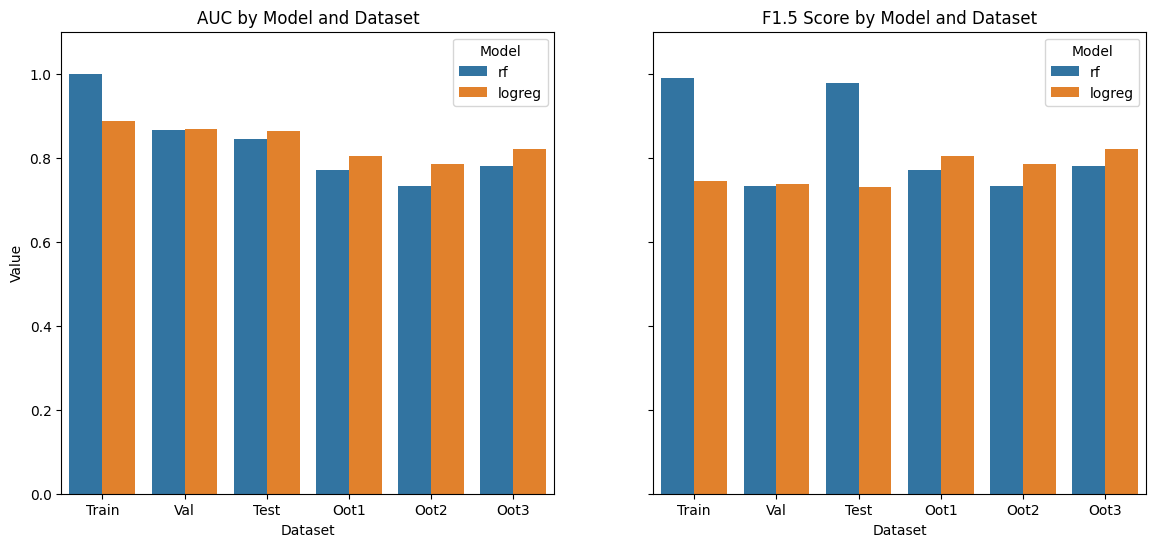

In [102]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Subset for each metric
for i, metric_name in enumerate(['AUC', 'F1.5 Score']):
    sns.barplot(
        data=df_metrics[df_metrics['Metric'] == metric_name],
        x='Dataset',
        y='Value',
        hue='Model',
        ax=axes[i]
    )
    axes[i].set_title(f'{metric_name} by Model and Dataset')
    axes[i].set_ylim(0, 1.1)
    axes[i].legend(title='Model')

## Active model performance over time

Get current champion model

In [57]:
mlflow.set_tracking_uri(uri="http://mlflow:5001")
model_name = "creditkarma-scorer"

client = MlflowClient()
model_version = client.get_model_version_by_alias(model_name, "champion")
model_train_date = model_version.tags['train_date']
model_type = model_version.tags['model_type']

model_version_tag = f'{model_type}_{model_train_date}'

print("Current deployed model: ", model_version_tag)

Current deployed model:  logreg_2024-12-01


Get inference results from current deployed model

In [58]:
df_inference = read_gold_table(f'model_predictions/*', 'datamart/gold', spark)

In [59]:
df_inference_pd = df_inference.toPandas()
df_inference_pd = pd.merge(df_inference_pd, y_df, on="customer_id")
df_inference_pd = df_inference_pd[['customer_id', 'snapshot_date_x', 'model_version', 'default', 'label']] \
    .rename(columns={'snapshot_date_x': 'snapshot_date'})

In [60]:
df_inference_pd

,customer_id,snapshot_date,model_version,default,label
0,CUS_0xb6e7,2024-03-01,logreg_2024-01-01,True,1
1,CUS_0xb794,2024-03-01,logreg_2024-01-01,True,0
2,CUS_0xb837,2024-03-01,logreg_2024-01-01,True,1
3,CUS_0xb8c,2024-03-01,logreg_2024-01-01,True,1
4,CUS_0xb8e5,2024-03-01,logreg_2024-01-01,False,0
...,...,...,...,...,...
25327,CUS_0x5f89,2023-09-01,logreg_2024-01-01,True,0
25328,CUS_0x5fec,2023-09-01,logreg_2024-01-01,True,0
25329,CUS_0x6048,2023-09-01,logreg_2024-01-01,True,1
25330,CUS_0x60c8,2023-09-01,logreg_2024-01-01,False,0


Compute F1.5 Score

In [61]:
def compute_fb_by_snapshot(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute F1.5 score grouped by snapshot_date.
    """
    results = []

    grouped = df.groupby(["snapshot_date", "model_version"])

    for (snapshot_date, model_version), group in grouped:
        y_true = group["label"]
        y_pred = (group["default"]).astype(int)

        # Compute F1.5 score (handle edge cases like all one class)
        if y_true.nunique() == 1 and y_pred.nunique() == 1 and y_true.iloc[0] == y_pred.iloc[0]:
            f15 = 1.0  # Perfect match
        else:
            f15 = fbeta_score(y_true, y_pred, beta=1.5, zero_division=0)

        results.append({
            "model_version": model_version,
            "snapshot_date": snapshot_date,
            "f1_5_score": f15
        })

    return pd.DataFrame(results)

In [62]:
df_fb = compute_fb_by_snapshot(df_inference_pd).sort_values(by="snapshot_date")

df_fb

,model_version,snapshot_date,f1_5_score
0,logreg_2024-01-01,2023-02-01,0.668457
1,logreg_2024-06-01,2023-02-01,0.681319
2,logreg_2024-12-01,2023-02-01,0.642607
3,logreg_2024-01-01,2023-03-01,0.683466
4,logreg_2024-06-01,2023-03-01,0.704123
5,logreg_2024-12-01,2023-03-01,0.702110
6,logreg_2024-01-01,2023-04-01,0.622535
7,logreg_2024-06-01,2023-04-01,0.690160
8,logreg_2024-12-01,2023-04-01,0.669343
9,logreg_2024-01-01,2023-05-01,0.640954


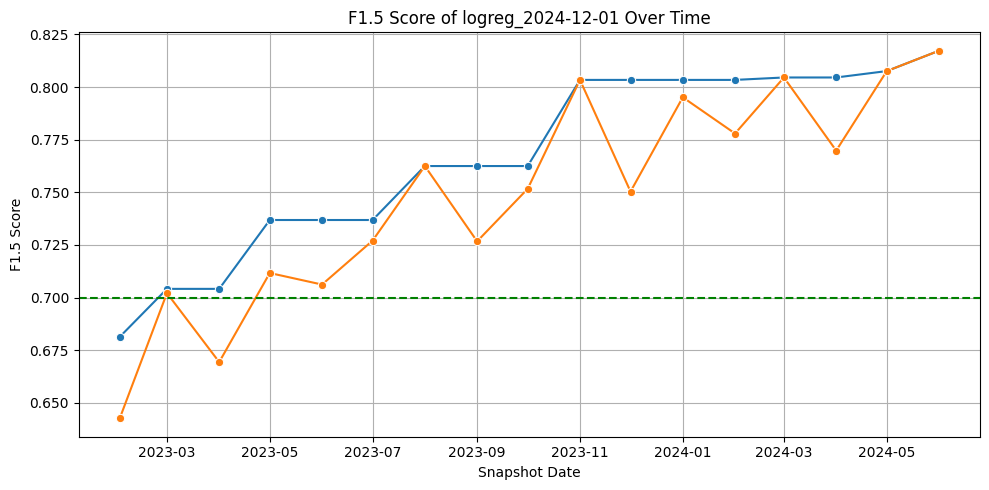

In [73]:
df_current_fb = df_fb[df_fb["model_version"] == model_version_tag]

# Get cumulative max
df_max_fb = df_fb.sort_values("snapshot_date") \
    .groupby("snapshot_date", as_index=False)["f1_5_score"].max()
df_max_fb["cumulative_max_f1_5_score"] = df_max_fb["f1_5_score"].cummax()

plt.figure(figsize=(10, 5))
sns.lineplot(data=df_max_fb, x="snapshot_date", y="cumulative_max_f1_5_score", marker="o")
sns.lineplot(data=df_current_fb, x="snapshot_date", y="f1_5_score", marker="o")

plt.title(f"F1.5 Score of {model_version_tag} Over Time")
plt.xlabel("Snapshot Date")
plt.ylabel("F1.5 Score")
plt.axhline(y=0.7, label="Business Req", color="green", linestyle="--")
plt.grid(True)
plt.tight_layout()
plt.show()